In [1]:
import warnings
warnings.filterwarnings('ignore')

from sentence_transformers import SentenceTransformer

model = SentenceTransformer("all-MiniLM-L6-v2")
model

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

In [2]:
tokenized_data = model.tokenize(["walker walked a long walk"])
tokenized_data

{'input_ids': tensor([[ 101, 5232, 2939, 1037, 2146, 3328,  102]]),
 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0]]),
 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}

In [3]:
model.tokenizer.convert_ids_to_tokens(tokenized_data["input_ids"][0])

['[CLS]', 'walker', 'walked', 'a', 'long', 'walk', '[SEP]']

In [4]:
# Transformer consists of multiple stack modules. Tokens are an input
# of the first one, so we can ignore the rest.
first_module = model._first_module()
first_module.auto_model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 384, padding_idx=0)
    (position_embeddings): Embedding(512, 384)
    (token_type_embeddings): Embedding(2, 384)
    (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-5): 6 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=384, out_features=384, bias=True)
            (key): Linear(in_features=384, out_features=384, bias=True)
            (value): Linear(in_features=384, out_features=384, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=384, out_features=384, bias=True)
            (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
    

In [5]:
embeddings = first_module.auto_model.embeddings
embeddings

BertEmbeddings(
  (word_embeddings): Embedding(30522, 384, padding_idx=0)
  (position_embeddings): Embedding(512, 384)
  (token_type_embeddings): Embedding(2, 384)
  (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [8]:
import torch
import plotly.express as px

device = torch.device("mps" if torch.has_mps else "cpu")  # Use MPS for Apple, CUDA for others, or fallback to CPU

first_sentence = "vector search optimization"
second_sentence = "Sulaiman illustrates how to apply vector search optimization"

with torch.no_grad():
    # Tokenize both texts
    first_tokens = model.tokenize([first_sentence])
    second_tokens = model.tokenize([second_sentence])
    
    # Get the corresponding embeddings
    first_embeddings = embeddings.word_embeddings(
        first_tokens["input_ids"].to(device)
    )
    second_embeddings = embeddings.word_embeddings(
        second_tokens["input_ids"].to(device)
    )

first_embeddings.shape, second_embeddings.shape

(torch.Size([1, 5, 384]), torch.Size([1, 12, 384]))

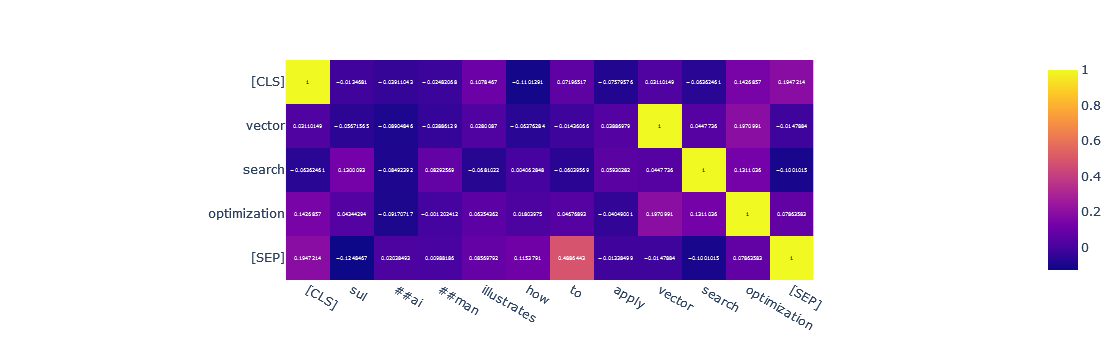

In [9]:
from sentence_transformers import util

distances = util.cos_sim(
    first_embeddings.squeeze(), 
    second_embeddings.squeeze()
).cpu().numpy() # Move the tensor to the CPU and convert to a NumPy array

px.imshow(
    distances, 
    x=model.tokenizer.convert_ids_to_tokens(
        second_tokens["input_ids"][0]
    ),
    y=model.tokenizer.convert_ids_to_tokens(
        first_tokens["input_ids"][0]
    ),
    text_auto=True,
)